In [1]:
#Scheme 1 (Numerics, Paper 2), ref Scheme_1_two_scale.ipynb)
#(Numerical Study of a Strongly Coupled Two-scale System with1 Nonlinear Dispersion)

#import libraries
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)


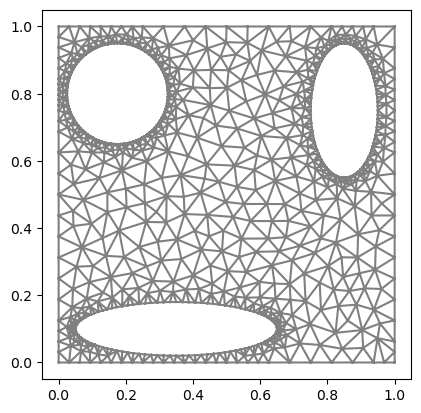

In [2]:
#Geometry for micro problem
L = 1.0 #lenght of domain
W = 1.0 #width of the domain
x_0 = 0.85
y_0 = 0.75
x_1 = 0.35
y_1  =  0.1
x_2 = 0.175
y_2  =  0.8
center0 = Point(x_0, y_0)
center1 = Point(x_1, y_1)
center2 = Point(x_2, y_2)
horizontal_semi_axis_0 = 0.1
vertical_semi_axis_0 = 0.2
horizontal_semi_axis_1 = 0.30
vertical_semi_axis_1 = 0.08
horizontal_semi_axis_2 = 0.15
vertical_semi_axis_2 = 0.15
def Geometry1():
    # Define domain for cell probem 
    #define geometry 1
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
         - mshr.Ellipse(center0, horizontal_semi_axis_0, vertical_semi_axis_0, 100) - mshr.Ellipse(center1, horizontal_semi_axis_1, vertical_semi_axis_1, 100) \
           - mshr.Ellipse(center2, horizontal_semi_axis_2, vertical_semi_axis_2, 100)
    # Build mesh
    mesh1 = mshr.generate_mesh(geometry, 15)
    return mesh1
mesh = Geometry1()
plot(mesh)

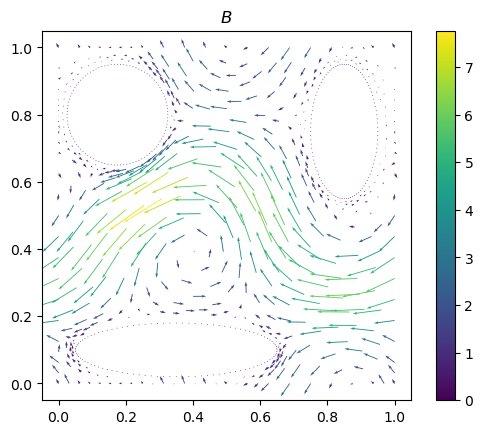

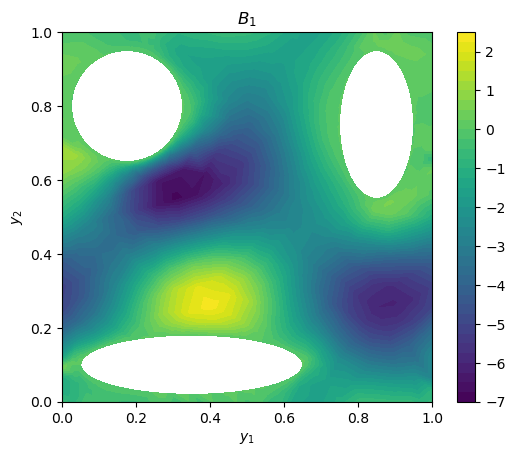

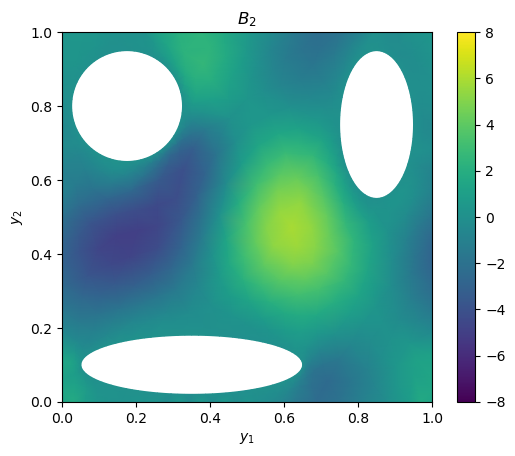

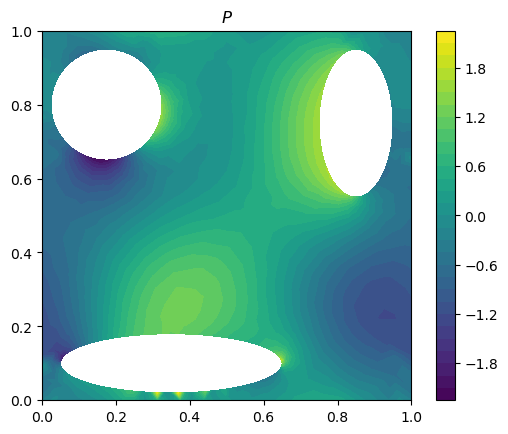

In [3]:
#solve the Stoke's Problem

from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

# Define domain for cell probem and B
set_log_active(False)
mesh = Geometry1()

# Construct facet markers
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1) 
for f in facets(mesh):
    mp = f.midpoint()
    if near(mp[0], 0.0) or near(mp[0], L): # left and right boundary is marked 1
        bndry[f] = 1
    elif near(mp[1], 0.0) or near(mp[1], W): # top and bottom boundary is marked 3
        bndry[f] = 3
    elif ((mp[0]- x_0)/horizontal_semi_axis_0)**2 + ((mp[1]-y_0)/vertical_semi_axis_0)**2 <=1: # elllipse is marked as 5
        bndry[f] = 5
    elif ((mp[0]- x_1)/horizontal_semi_axis_1)**2 + ((mp[1]-y_1)/vertical_semi_axis_1)**2 <=1: # elllipse is marked as 5
        bndry[f] = 5
    elif ((mp[0]- x_2)/horizontal_semi_axis_2)**2 + ((mp[1]-y_2)/vertical_semi_axis_2)**2 <=1: # elllipse is marked as 5
        bndry[f] = 5     

###periodic boundary conndition
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
    # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1
            y[1] = x[1] - 1
        elif near(x[0], 1):
            y[0] = x[0] - 1
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1
PbcUnit = PeriodicBoundary() 

P0 = VectorElement('P', mesh.ufl_cell(), 2) #  Here  we used the Taylor-Hood element, second order Lagrange basis element for each component of velocity and first order for pressure   
P1 = FiniteElement('P', mesh.ufl_cell(), 1) #  first order lagrange element  for pressure.
TH = P0 * P1 

W = FunctionSpace(mesh, TH, constrained_domain = PbcUnit) # Mixed function space with periodic boundary condition in outer boundary
BC_value_circle = Constant((0, 0)) #Boundary value on the inner circle
bc_circle = DirichletBC(W.sub(0), BC_value_circle, bndry, 5) #Impelemntation of BC on inner circle
# Collect boundary conditions
bcs = [bc_circle]
nu = Constant(0.01) #Viscocity

#right hand side finction
F = Expression(("10*(sin(2*pi*x[0])*sin(2*pi*x[1]))", '10*(sin(2*pi*x[0])*cos(2*pi*x[1]))'), degree =2)

def stokes():
    # Define variational forms for Stokes
    def a(u,v):
        return inner(nu*grad(u), grad(v))*dx
    def b(p,v):
        return p*div(v)*dx
    def L(v):
        return inner(F, v)*dx
    
    # Solve the problem
    B, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    w = Function(W)
    solve(a(B, v) - b(p, v) + b(q, B) == L(v), w, bcs)

    return w
if __name__ == "__main__":
    for problem in [stokes]:
        #begin("Running '%s'" % problem.__name__)

        # Call solver
        w = problem()

        # Extract solutions
        B, p = w.split()
        plt.colorbar(plot((B)))
        plt.title("$B$")
        plt.show()
        ###plot B_1
        plt.colorbar(plot((B[0])))
        #plt.colorbar(plot((B[0]), mode = 'color', vmin=-8, vmax=8))
        plt.title("$B_1$")
        plt.xlabel('$y_1$')
        plt.ylabel('$y_2$')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()
         ###plot B_2
        plt.colorbar(plot((B[1]), mode = 'color', vmin=-8, vmax=8))
        #plt.colorbar()
        plt.title("$B_2$")
        plt.xlabel('$y_1$')
        plt.ylabel('$y_2$')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()
        plt.colorbar(plot((p)))
        plt.title("$P$")
        plt.show()
        end()

        

In [4]:
#Scheme 1 (To compute D*)
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
def D_star(p, B_y, mesh):
    
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 +sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    
    #e_1 and e_2
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    
    #define finite elemment
    P2= FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
     
    #define function space    
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    
    #area of Y
    area = assemble(Constant(1.0)*dx(mesh))
    #print('Area of the domain =', area)
    
    #initialized the component of homogenized matrix
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    
    for i in range(number_of_vertices):
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        
        # Compute cell solution w_2
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
    
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()
        
        #computing component of homogenized matrix
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the lise D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the lise D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the lise D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the lise D_HOM_22.
        
    d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
    #print('number_of_vertices=', number_of_vertices)
    
    # list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
    Vertex_values_D_11 = [D_HOM_11[d2v[i]] for i in range(number_of_vertices)]   
    Vertex_values_D_12 = [D_HOM_12[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_21 = [D_HOM_21[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_22 = [D_HOM_22[d2v[i]] for i in range(number_of_vertices)]
    
     ###initializing the each component of  D^* to a  function (componenetwise) in function space V
    D_star_11 = Function(V)
    D_star_12 = Function(V)
    D_star_21 = Function(V)
    D_star_22 = Function(V)
    
    ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
    D_star_11.vector()[:] = Vertex_values_D_11
    D_star_12.vector()[:] = Vertex_values_D_12
    D_star_21.vector()[:] = Vertex_values_D_21
    D_star_22.vector()[:] = Vertex_values_D_22 

    #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
    D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
    return D_star_k_plus_1

In [ ]:
#Section 5.2 (Table 1 corresponding to nx = 64, and computaitonal time and eroor  in Table 2 )
from dolfin import *
from datetime import datetime
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time

#discreteize domain omega
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2

T = 2 #final time
nxs = [4, 8, 16, 32, 64] #number of macro node in one direction DOFS = [4^2, 8^2, 16^2, 32^2, 64^2]
Ms =  [20, 20, 20, 20, 20] #number of time steps (i.e., M+1 time nodes )
micro_nxs = [15, 15, 15, 15, 15] # this will be used to save the data with  number of macro node
Hs_scheme1 = []
U_FOR_MACRO_VARY_Scheme1 = [] #U_FOR_MACRO_VARY for the precomputing 
for nx, M, nx_micro  in zip(nxs, Ms, micro_nxs):
    start_time = time.time()
    print(nx, M, nx_micro)
    #M = 20 # number of time steps (i.e., M+1 time nodes )
    dt = T/M
    L = 1.0
    W = 1.0
    #intitlal iteration function  
    u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)

    #source term
    f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
    #f = Expression("10*(2 + (sin(2*pi*x[0])*sin(2*pi*x[1])))", degree =2)

    ###########

    #construct Mesh for omega
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    number_of_vertices = Mesh.num_vertices()
    print('number_of_vertices=', number_of_vertices)
    Hs_scheme1.append(Mesh.hmax())
    print(Hs_scheme1)

    #define a function space
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    u_0 = interpolate(u_in, V) #interpolation of initial iteration function on finite element space
    UU_0 = [u_0]*(M+1) # initial guess solution for all time slice (interpoleted function in V)  
    U_0 = u_0.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
    U_0_time = [U_0]*(M+1) # vertex values for each time step after  iterpolation the initial iteration function 

    #define 0 Dirichlet boundary condition
    def Boundary_condition(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0.0), Boundary_condition) # zero Dirichlet boundary condition

    #define G(u)
    def G(u):
        return 1- 2*u

    #define micro mesh
    mesh = Geometry1()

    #initialize list to store all iterative solutions (fenics objects) 
    UU_T =[]

    #append the initial iterative guess in UU_T
    UU_T.append(UU_0)
    U_Store_iter = []
    maxiter = 10
    err = [1]      # error measure ||u-u_k||
    tol = 1.0E-7        # tolerance
    iter = 0  # 
    while err[-1] > tol and iter < maxiter:
        print('iteration=', iter)
        u_n.assign(u_0)  #initial condition for each iteration 
        #u_n = interpolate(u_in, V)

        u_store = []
        UU_store =[] # store a computed u for each time step 
        UU_store.append(u_n)
        u_store.append(U_0)
        Error =[]
        iter= iter+1
        for j in range(M):
            D_star_k_plus_1_G1 = D_star(G(U_0_time[j]), B, mesh) 
            u = TrialFunction(V)
            v = TestFunction(V)
            #F = u*v*dx + dt*dot(D_star_k_plus_1_time[j]*grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
            F = u*v*dx + dt*dot(D_star_k_plus_1_G1*grad(u), grad(v))*dx(domain=Mesh)  - (u_n + dt*f)*v*dx(domain=Mesh) 
            a, L = lhs(F), rhs(F)
            u = Function(V)
            #t = t +dt
            solve(a == L, u, bc)
            UU_store.append(u)#store each time step solution u in UU_store list
            
            #compute error
            error = errornorm(u, UU_0[j+1], norm_type='L2') # compute error between two consecutive iteration solution for each time step
            Error.append(error**2)
            
            vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
            #print('error=', error)
            u_store.append(vertex_values_u) #store the vertex values solution in u_store list
            u_n = u.copy() #assign the computed solution to a new u_n  
        UU_T.append(UU_store) #Store the solution u for each time step and for each iteration.  
        U_Store_iter.append(u_store)
        
        Error_in_L_2_time= np.sqrt(dt*sum(Error))
        err.append(Error_in_L_2_time)
        print(err[1:])
        plt.colorbar(plot(u))
        plt.show()
        U_0_time = u_store.copy()
        UU_0 = UU_store.copy()
    U_FOR_MACRO_VARY_Scheme1.append(UU_T)
    #np.save(f"Two_scale_paper2/Scheme1_macro_vary/scheme1_u_nx_{nx}M_{M}nxmicro_{nx_micro}.npy",U_Store_iter)
    #np.save(f"Two_scale_paper2/Scheme1_macro_vary/scheme1_it_error_nx_{nx}M_{M}nxmicro_{nx_micro}.npy",err[1:])
    end_time = time.time()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Finished Time =", current_time)
    print('computation time=', (end_time - start_time), 'seconds')


In [ ]:
#compute e_(k+1)/e_k Table 1
error_scheme1 = err[1:]
for i in range(len(error_scheme1)-1):
    e_kDe_kplus1 = error_scheme1[i+1]/error_scheme1[i]
    print(e_kDe_kplus1)

In [ ]:
#compute the error and convergence rate, Table 2 in Section 5.3
import math
#initialize error for shceme2 Hs_scheme2[i]/Hs_scheme2[i+1
Error_in_scheme1 = []
for i, k in zip(range(len(U_FOR_MACRO_VARY_Scheme1[-1])-1),range(len(Ms)-1)):
    print('i=', i)
    Errors_in_nx = []
    dt = T/Ms[k]
    #print(dt)
    for j in range(Ms[k]+1):
        error_in_time_slice = errornorm(U_FOR_MACRO_VARY_Scheme1[i+1][-1][j], U_FOR_MACRO_VARY_Scheme1[i][-1][j], norm_type ='L2')
        print(error_in_time_slice)
        Errors_in_nx.append(error_in_time_slice**2)
    Error_in_L_2_T = np.sqrt(dt*np.sum(Errors_in_nx))
    Error_in_scheme1.append(Error_in_L_2_T)  
print('Error_in_scheme2=', Error_in_scheme1)  

#Computing convergence rate
convergence_rate =[]
def convergence_order():
    for i in range(len(Error_in_scheme1)-1):
        rate = math.log(Error_in_scheme1[i]/Error_in_scheme1[i+1])/math.log(Hs_scheme1[i]/Hs_scheme1[i+1])
        convergence_rate.append(rate)
    return convergence_rate
RATE = convergence_order()
print('convergence order of scheme 2 =', RATE) 

In [10]:
#Precomputing# auxuliary problem (Input: a vector of p values, B, mesh; our put: entries of D_star matrix )
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
def D_star(p, B_y, mesh):
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 +sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    #D_11 = Expression('0.05 +(1/50)*sin(pi*x[0])*sin(pi*x[1])', degree =1) #slow diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    #D_22 = Expression('0.05 +(1/50)*sin(2*pi*x[0])', degree =1) #slow diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    P2 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
    area = assemble(Constant(1.0)*dx(mesh)) #Area of the domain
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    for i in range(number_of_points):
         #Solve w1
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
        
        #Solve w2
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()
        
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the lise D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the lise D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the lise D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the lise D_HOM_22.
    return D_HOM_11, D_HOM_12, D_HOM_21, D_HOM_22

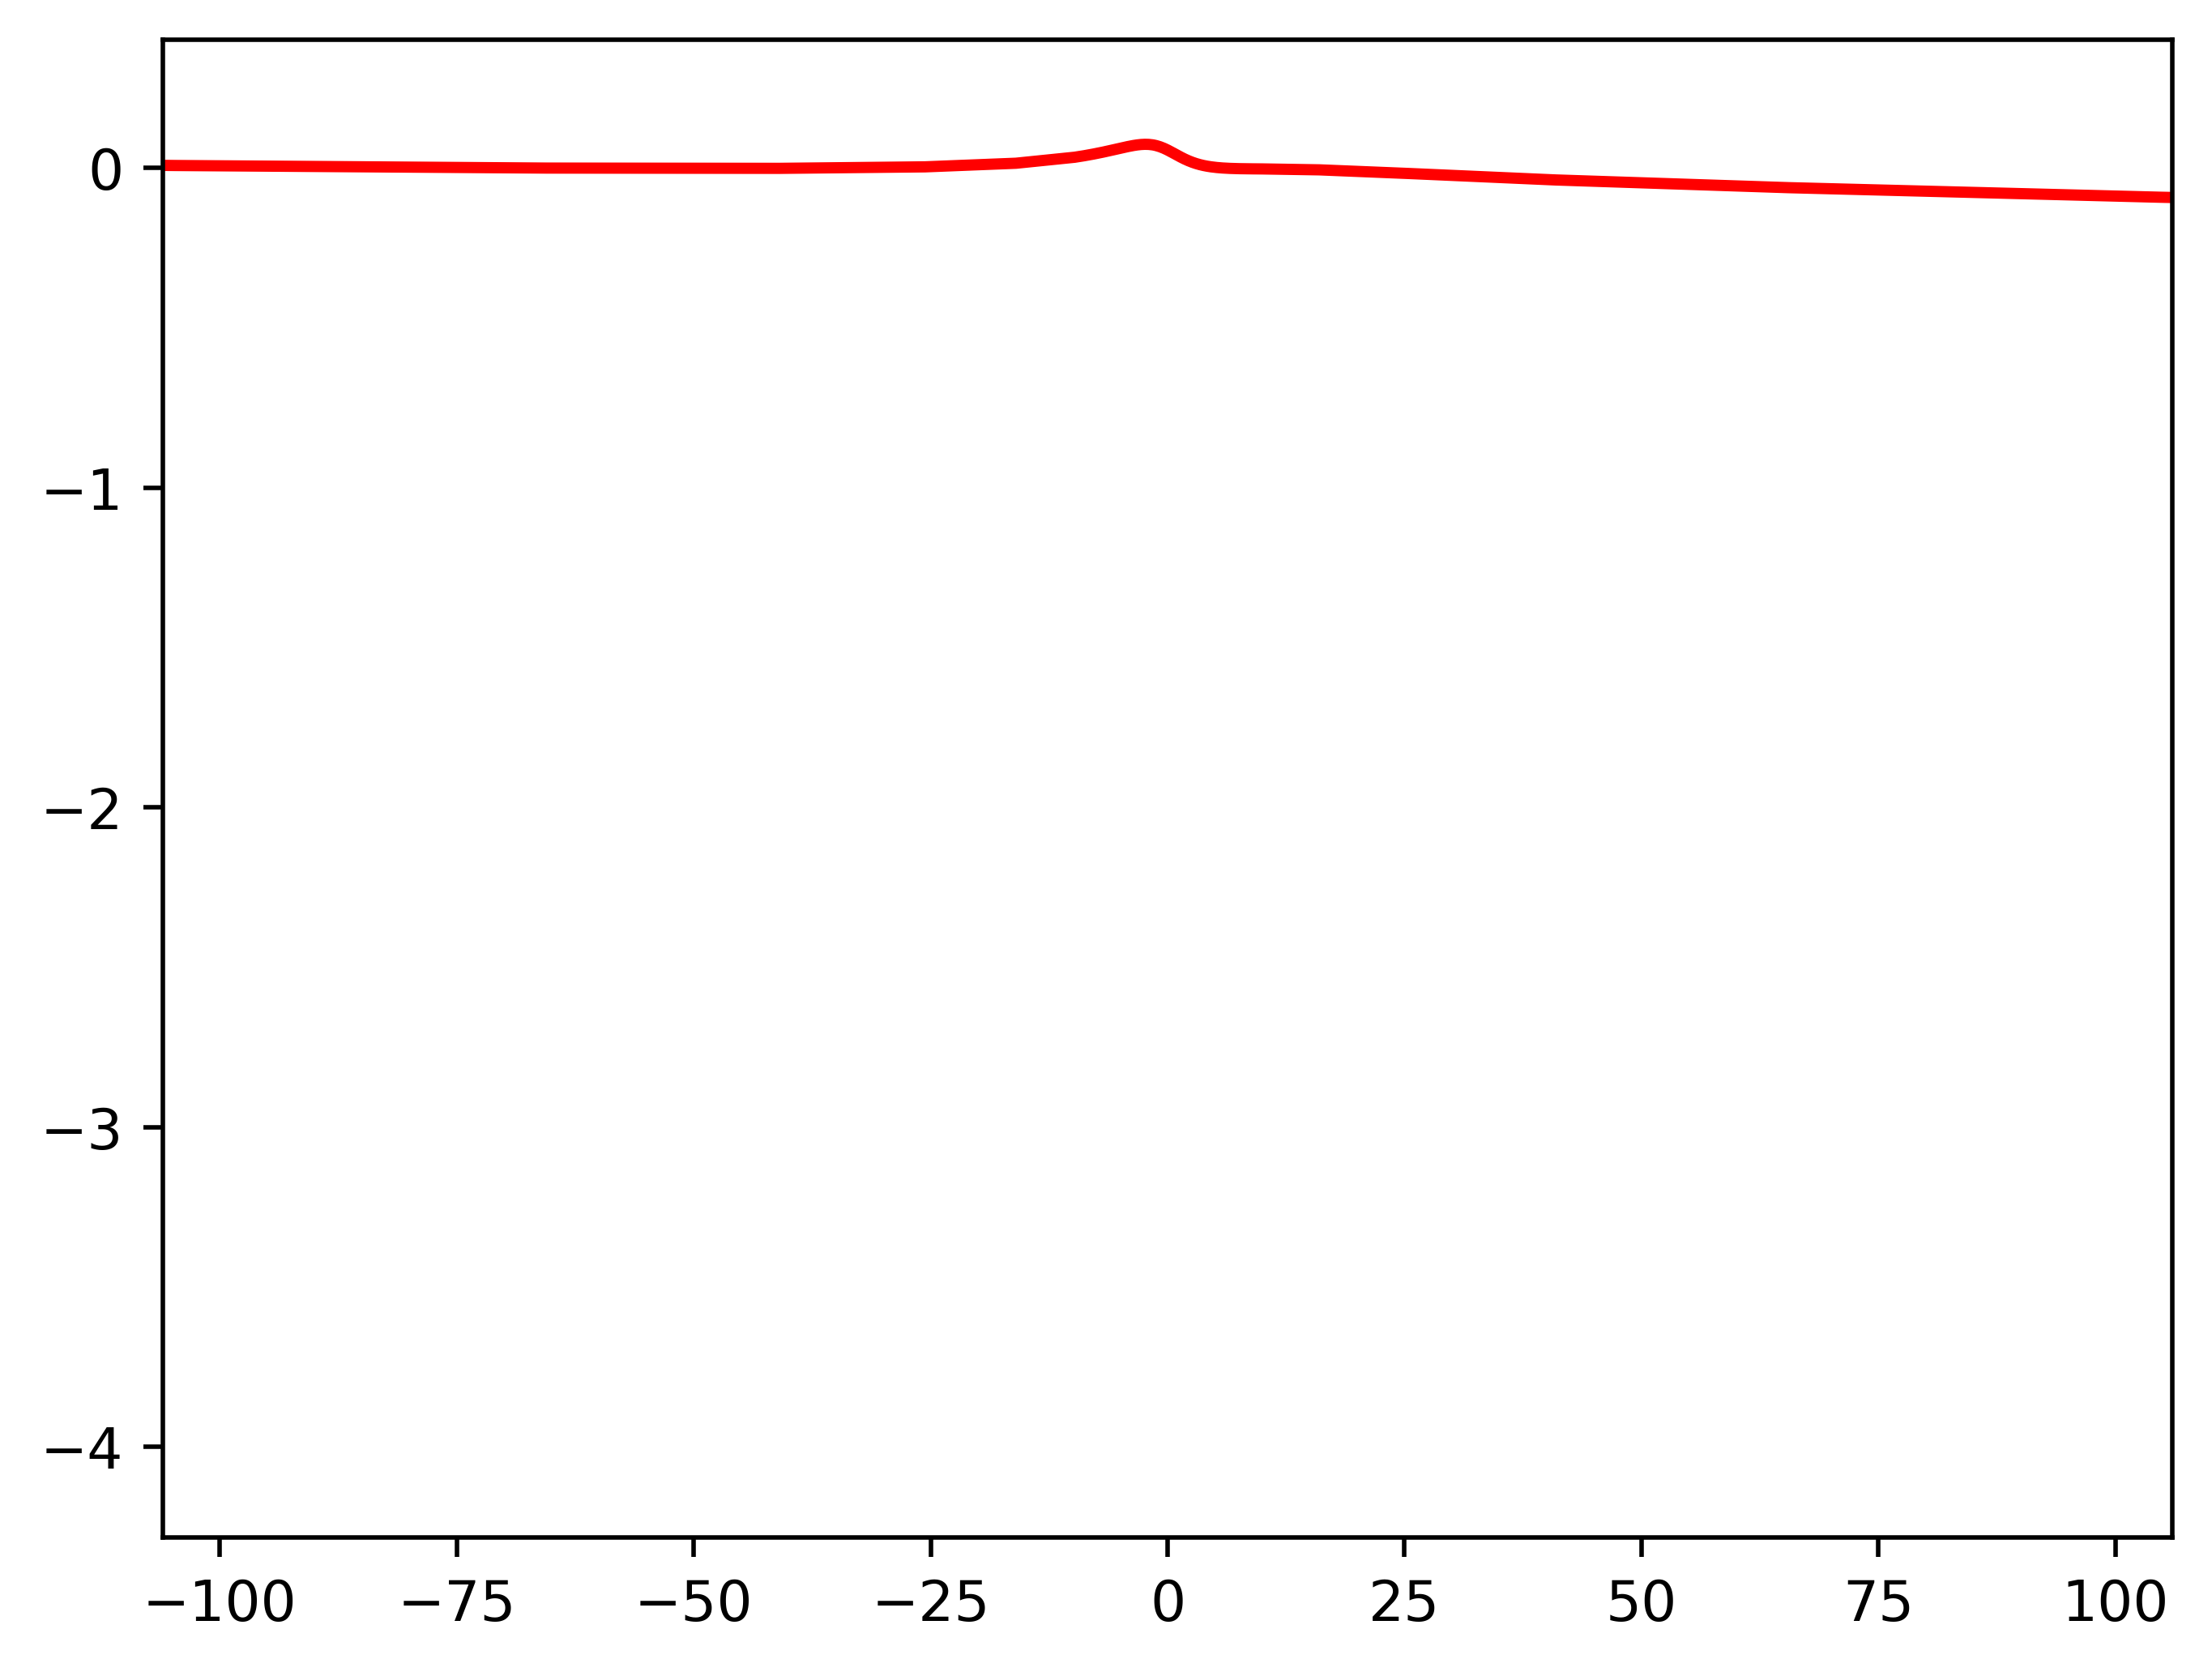

computation time is 0.6376983006795247 minutes


In [11]:
import time
start_time = time.time()
L = 1
W =1
#X = np.linspace(-10, 10, number_of_points)
x1 = -np.logspace(0, 10, 50, endpoint=True)[::-1]*10
x2 = np.linspace(x1[-1], -x1[-1], 101)
x3 = np.logspace(0, 10, 50, endpoint=True)*10
p_i = np.concatenate((x1, x2, x3), axis=0)
XX = np.sort(p_i)
number_of_points = len(XX)
mesh = Geometry1()
D_hom = D_star(XX, B, Geometry1())
fig = plt.figure(dpi=500)
plt.plot(XX, np.array(D_hom[2]), 'r-',  linewidth=2)
plt.xlim(-106,106)
plt.show()
end_time = time.time() 
computation_time = (end_time-start_time)/60
print('computation time is', computation_time, 'minutes')

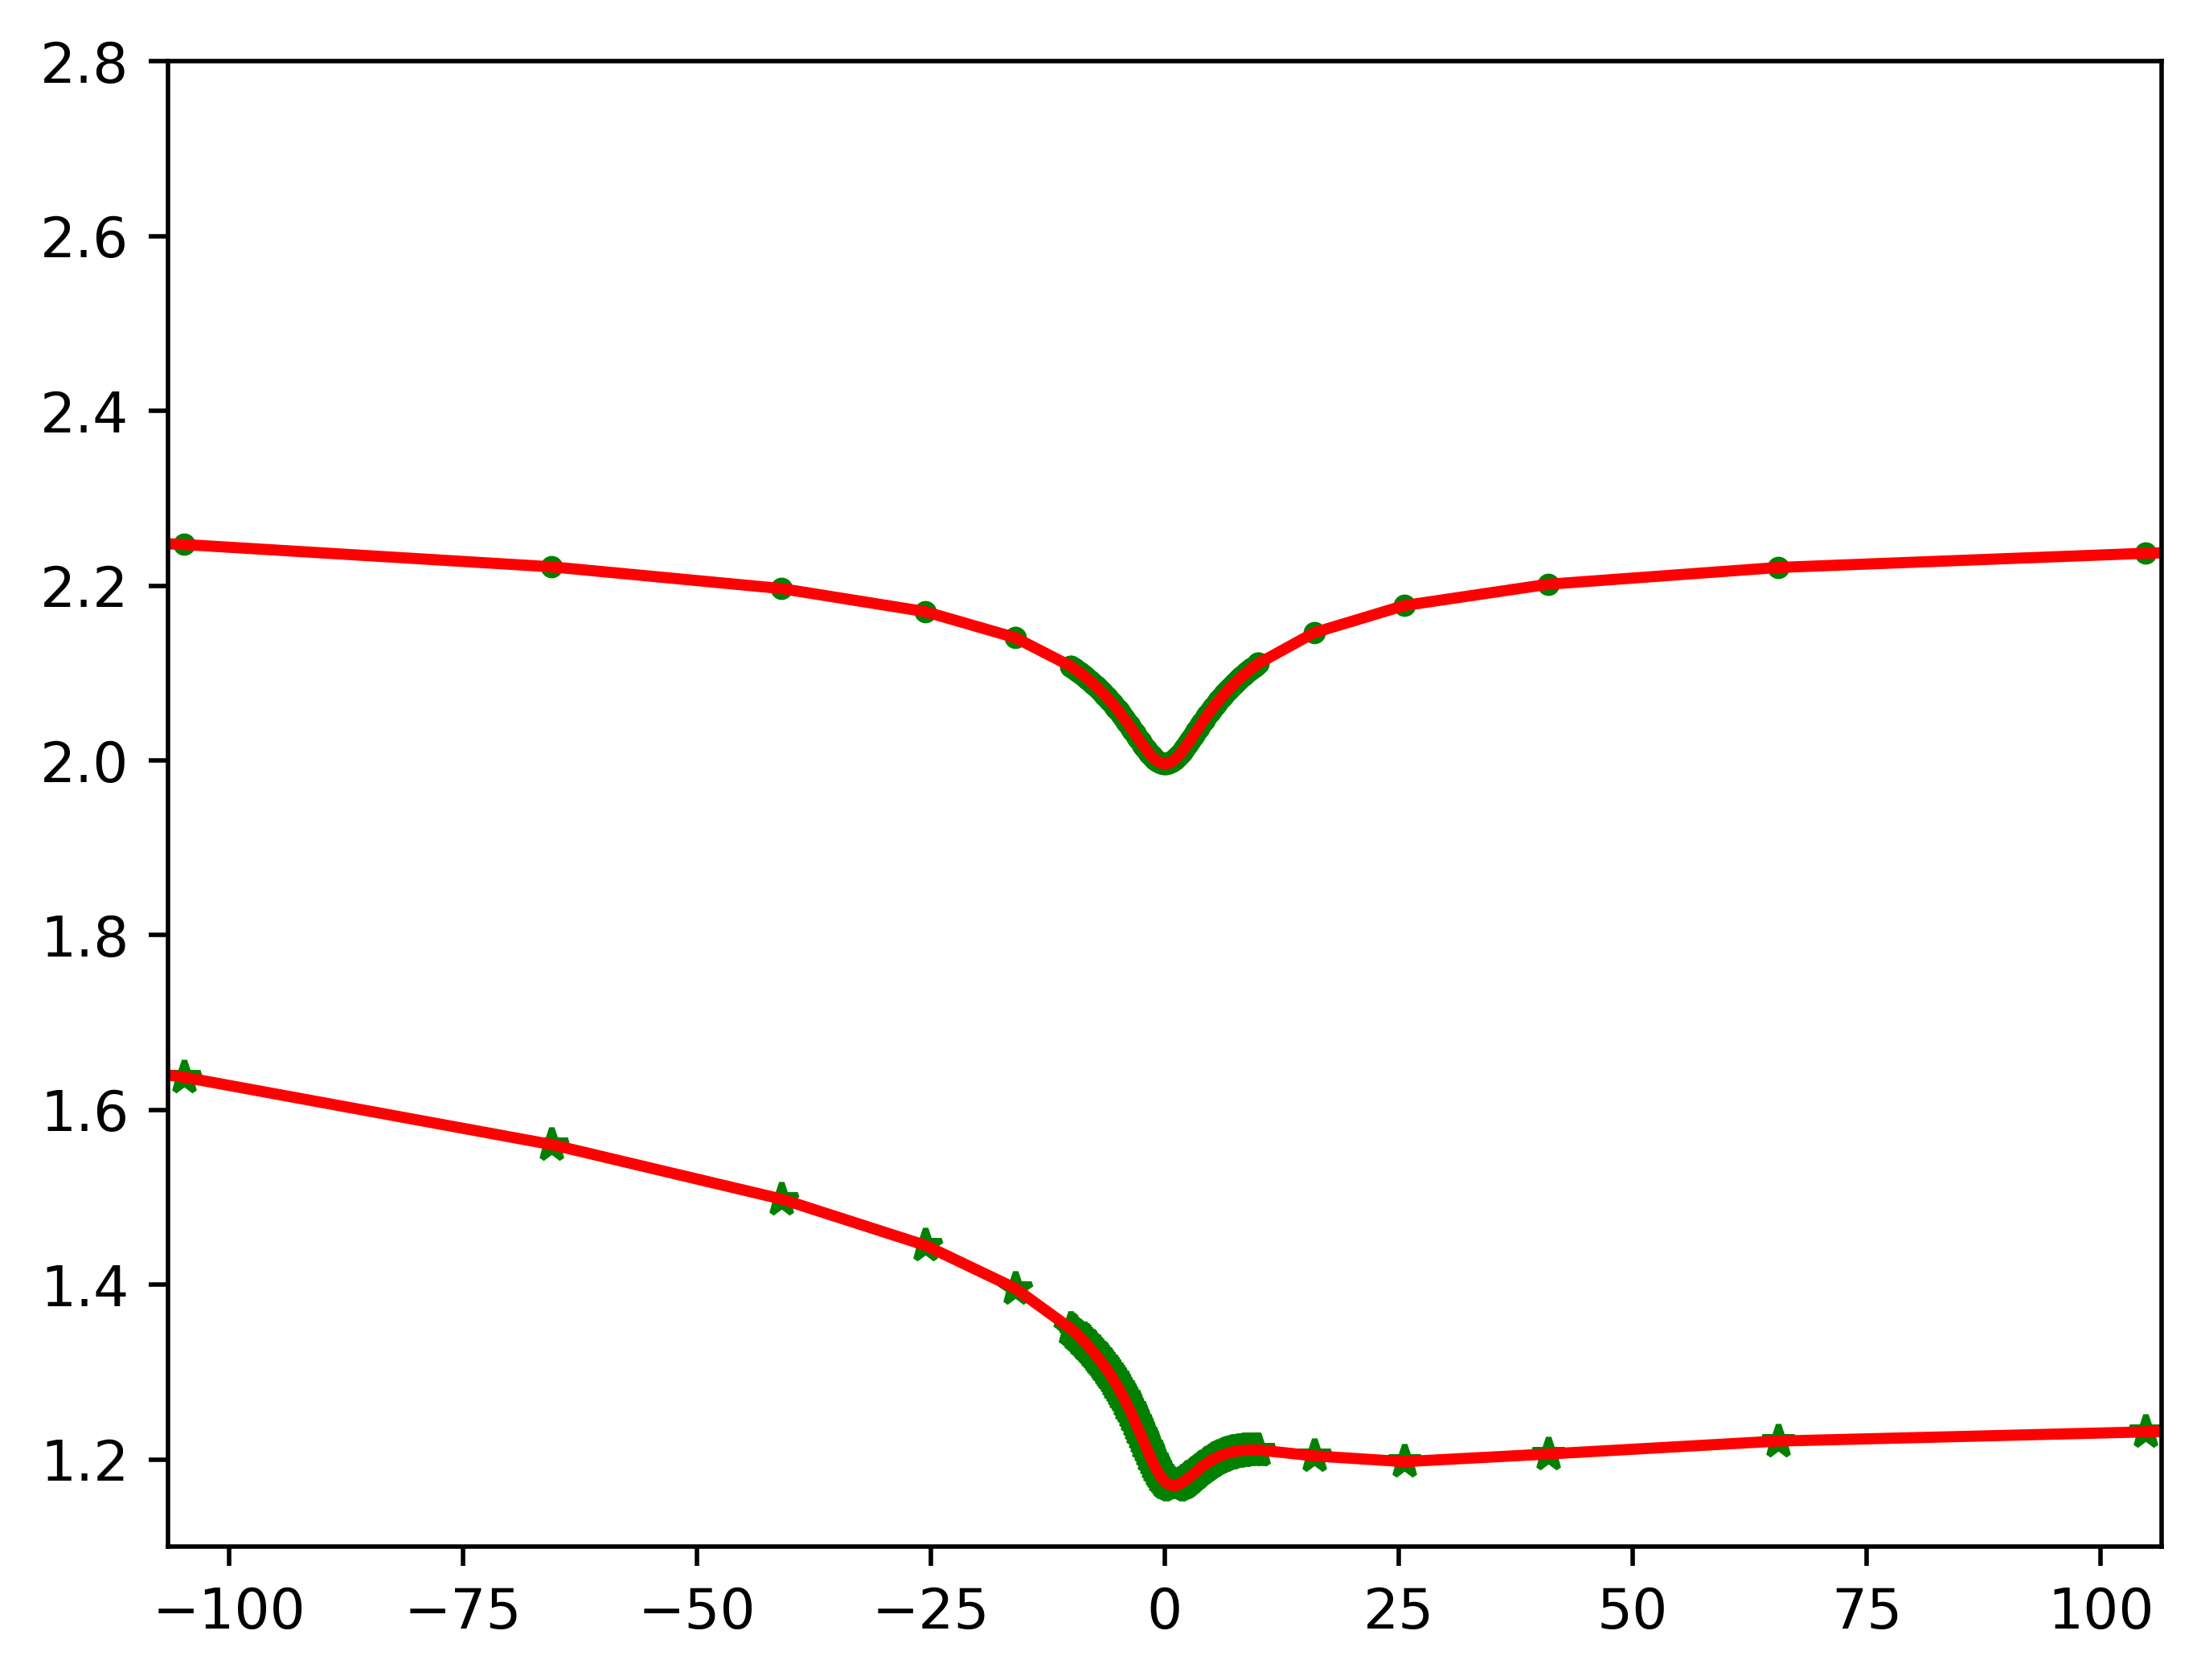

In [9]:
fig = plt.figure(dpi=500)
plt.plot(XX, np.array(D_hom[0]), 'g .',  linewidth=2)
plt.plot(XX, np.array(D_hom[0]), 'r-',  linewidth=2)
plt.plot(XX, np.array(D_hom[3]), 'g*',  linewidth=2)
plt.plot(XX, np.array(D_hom[3]), 'r-',  linewidth=2)
#plt.plot(X, np.array(D_star_geometry_2[0]), 'g--',  linewidth=2)
#plt.xlim(np.min(P_i), np.max(P_i))
plt.xlim(-106.5,106.5)
plt.ylim(1.1, 2.8)
plt.show()

In [ ]:
#Method 1 (Precomputing) for error macro mesh vary 
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2
L = 1.0
W = 1.0
T = 2
nxs = [4, 8, 16, 32, 64]
Ms =  [20, 20, 20, 20, 20] #number of time steps (i.e., M+1 time nodes )
micro_nxs = [15, 15, 15, 15, 15]
Hs_scheme1_precompute = []
U_FOR_MACRO_VARY = []

for nx, M, nx_micro  in zip(nxs, Ms, micro_nxs):
    print(nx, M, nx_micro)
    start_time = time.time()
    dt = T/M
    #u_in  = Constant(1.0) #intitlal iteration function 
    u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
    
    #f = Expression("1000*exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 0.5 )", degree =2)
    f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)

    ###########
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    number_of_vertices = Mesh.num_vertices()
    print('number_of_vertices=', number_of_vertices)
    Hs_scheme1_precompute.append(Mesh.hmax())
    print(Hs_scheme1_precompute)
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    u_0 = interpolate(u_in, V) #interpolation of initial iteration function on finite element space

    UU_0 = [u_0]*(M+1) # initial guess solution for all time slice (interpoleted function in V)  
    U_0 = u_0.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
    U_0_time = [U_0]*(M+1) # vertex values for each time step after  iterpolation the initial iteration function 
    def Boundary_condition(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0.0), Boundary_condition) # zero Dirichlet boundary condition
    
    def G(u):
        return 1- 2*u
    UU_T =[]
    UU_T.append(UU_0)
    #print(UU_T)
    U_Store_iter = []
    t = 0
    maxiter = 10
    err = [1]      # error measure ||u-u_k||
    tol = 1.0E-7        # tolerance
    iter = 0  # 

    while err[-1] > tol and iter < maxiter:

        u_n.assign(u_0)  #initial condition for each iteration 
    
        u_store = []
        UU_store =[] # store a computed u for each time step 
        UU_store.append(u_n)
        u_store.append(U_0)
        #print(UU_store[0].compute_vertex_values(Mesh))
        Error =[]
        iter= iter+1

        for j in range(M):
            D_INTERPOLATE_11 = []
            D_INTERPOLATE_12 = []
            D_INTERPOLATE_21 = []
            D_INTERPOLATE_22 = []

            for i in range(number_of_vertices):
                D_interpolate_11 = np.interp(G(U_0_time[j][i]), XX, D_hom[0])
                D_interpolate_12 = np.interp(G(U_0_time[j][i]), XX, D_hom[1])
                D_interpolate_21 = np.interp(G(U_0_time[j][i]), XX, D_hom[2])
                D_interpolate_22 = np.interp(G(U_0_time[j][i]), XX, D_hom[3])
                D_INTERPOLATE_11.append(D_interpolate_11) 
                D_INTERPOLATE_12.append(D_interpolate_12) 
                D_INTERPOLATE_21.append(D_interpolate_21) 
                D_INTERPOLATE_22.append(D_interpolate_22)  

            d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
    

            # list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
            Vertex_values_D_11 = [D_INTERPOLATE_11[d2v[i]] for i in range(number_of_vertices)]   
            Vertex_values_D_12 = [D_INTERPOLATE_12[d2v[i]] for i in range(number_of_vertices)]
            Vertex_values_D_21 = [D_INTERPOLATE_21[d2v[i]] for i in range(number_of_vertices)]
            Vertex_values_D_22 = [D_INTERPOLATE_22[d2v[i]] for i in range(number_of_vertices)]

            ###initializing the each component of  D^* to a  function (componenetwise) in function space V
            D_star_11 = Function(V)
            D_star_12 = Function(V)
            D_star_21 = Function(V)
            D_star_22 = Function(V)

            ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
            D_star_11.vector()[:] = Vertex_values_D_11
            D_star_12.vector()[:] = Vertex_values_D_12
            D_star_21.vector()[:] = Vertex_values_D_21
            D_star_22.vector()[:] = Vertex_values_D_22 

            #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
            D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
            t = t + dt
            #print(t)
            #f.t = t

            u = TrialFunction(V)
            v = TestFunction(V)
            F = u*v*dx + dt*dot(D_star_k_plus_1*grad(u), grad(v))*dx(domain=Mesh)  - (u_n + dt*f)*v*dx(domain=Mesh) 
            a, L = lhs(F), rhs(F)
            u = Function(V)
            solve(a == L, u, bc)

            UU_store.append(u)#store each time step solution u in UU_store list
            #print('solution for time node=', UU_store[0].compute_vertex_values(Mesh))
            error = errornorm(u, UU_0[j+1], norm_type='L2') # compute error between two consecutive iteration solution for each time step
            #print('Error=', error)
            Error.append(error**2)
            vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
            #print('vetrex=', vertex_values_u)
            u_store.append(vertex_values_u) #store the vertex values solution in u_store list
            u_n = u.copy() #assign the computed solution to a new u_n  
        
        UU_T.append(UU_store) #Store the solution u for each time step and for each iteration.  
        
        U_Store_iter.append(u_store)
        
        #Error.append(error**2)
        Error_in_L_2_time= np.sqrt(dt*sum(Error))
        err.append(Error_in_L_2_time)
        print(err[1:])
        
        U_0_time = u_store.copy()
        UU_0 = UU_store.copy()

    U_FOR_MACRO_VARY.append(UU_T)
    #np.save(f"Two_scale_paper2/Scheme1_precompute_macro_vary/scheme1_precompute_u_nx_{nx}M_{M}nxmicro_{nx_micro}.npy",U_Store_iter)
    #np.save(f"Two_scale_paper2/Scheme1_precompute_macro_vary/scheme1_precompute_it_error_nx_{nx}M_{M}nxmicro_{nx_micro}.npy",err[1:])
    end_time = time.time()
    print('computation time=', (end_time - start_time), 'seconds')
#np.save(f"Two_scale_paper2/Scheme1_precompute_macro_vary/scheme1_precompute_Hs_nx_48163264_M_20nxmicro_15.npy",Hs_scheme1_precompute)    

In [ ]:
#compute e_(k+1)/e_k Table 1 (from precomputing, Scheme 1)
Error_iteration = err[1:]
ratio_error = []
for i in range(len(Error_iteration)-1):
    ratio_error_iter = Error_iteration[i+1]/Error_iteration[i]
    ratio_error.append(ratio_error_iter)
ratio_error   

In [ ]:
#compute the error and convergence rate, Table 2 in Section 5.3
import math
#initialize error for shceme2 
Error_in_scheme1_pre = []
for i, k in zip(range(len(U_FOR_MACRO_VARY[-1])-1),range(len(Ms)-1)):
    print('i=', i)
    Errors_in_nx = []
    dt = T/Ms[k]
    #print(dt)
    for j in range(Ms[k]+1):
        error_in_time_slice = errornorm(U_FOR_MACRO_VARY[i+1][-1][j], U_FOR_MACRO_VARY[i][-1][j], norm_type ='L2')
        print(error_in_time_slice)
        Errors_in_nx.append(error_in_time_slice**2)
    #tt = np.linspace(0, T, Ms[k]) 
    #plt.plot(np.log(tt), np.log(Errors_in_nx), '.', label='example1')
    #plt.legend(f'{j}example1')
    Error_in_L_2_T = np.sqrt(dt*np.sum(Errors_in_nx))
    Error_in_scheme1_pre.append(Error_in_L_2_T)  
print('Error_in_scheme2=', Error_in_scheme1_pre)  

#Computing convergence rate
convergence_rate =[]
def convergence_order():
    for i in range(len(Error_in_scheme1_pre)-1):
        rate = math.log(Error_in_scheme1_pre[i]/Error_in_scheme1_pre[i+1])/math.log(Hs_scheme1_precompute[i]/Hs_scheme1_precompute[i+1])
        convergence_rate.append(rate)
    return convergence_rate
RATE = convergence_order()
print('convergence order of scheme 2 =', RATE)